In [1]:
from classifier import (
    Ada,
    KNN,
    SVM,
)
from preprocess import (
    get_data_for_image,
    pca_transform,
)
from utils import (
    Constant,
    logger,
)
from utils.globals import (
    os,
    np,
    pd,
    plt,
    sns,
    cv2,
    pickle,
    shuffle,
    tnrange,
)
from utils.plot import (
    plot_image,
    plot_scatter,
)

In [2]:
VERBOSE = False

In [3]:
def fetch_image_paths_with_labels(verbose=False) -> ([str], [str]):
    writer_names = os.listdir(Constant.DATASET_PREPARED_IMAGES_PATH)

    image_paths = []
    image_labels = []
    for writer_name in writer_names:
        writer_path = os.path.join(Constant.DATASET_PREPARED_IMAGES_PATH, writer_name)
        image_names = os.listdir(writer_path)
        for image_name in image_names[:2]:
            image_paths.append(os.path.join(writer_path, image_name))
            image_labels.append(int(writer_name))

    if verbose:
        logger.info(f'Writers count: {len(writer_names)}')
        logger.info(f'Image paths loaded: {len(image_paths)}')

    return image_paths, image_labels

In [4]:
def fetch_images(image_paths: [str], image_labels: [str], verbose=False) -> [np.array]:
    N = len(image_paths)

    images = []
    labels = []
    data = zip(image_paths, image_labels)
    for i in tnrange(len(data)):
        image = cv2.imread(image_paths[i])
        for line_image in get_data_for_image(image):
            images.append(line_image)
            labels.append(image_labels[i])

    if verbose:
        logger.info(f'Images loaded: {len(images)}')
        plot_image(images[0], title='Original image')

    return np.array(images), np.array(labels)

In [25]:
image_paths, image_labels = fetch_image_paths_with_labels(verbose=VERBOSE)
X, Y = fetch_images(image_paths, image_labels, verbose=VERBOSE)

del image_paths, image_labels

In [26]:
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'transformed_X.pkl'), mode='wb') as X_file:
    pickle.dump(X, X_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'transformed_Y.pkl'), mode='wb') as Y_file:
    pickle.dump(Y, Y_file)

del X_file, Y_file

In [2]:
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'transformed_X.pkl'), mode='rb') as X_file:
    X = pickle.load(X_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'transformed_Y.pkl'), mode='rb') as Y_file:
    Y = pickle.load(Y_file)

del X_file, Y_file

In [6]:
def print_correlation_matrix(X, title):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    plt.subplots(figsize=(11, 9))
    plt.title(title)
    df = pd.DataFrame(X)
    corr = df.corr()
    sns.heatmap(corr, cmap=cmap)
    plt.show()

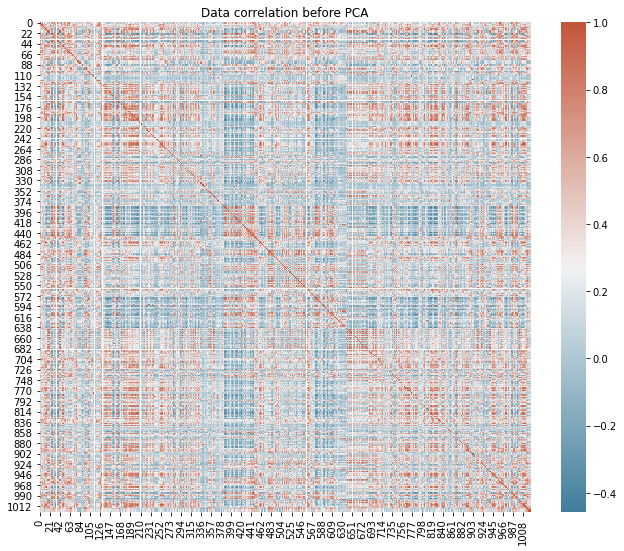

In [34]:
print_correlation_matrix(X, 'Data correlation before PCA')

In [3]:
X = pca_transform(X, min_components=6, verbose=True)

2021-05-06 19:44:37.172 | INFO     | preprocess.preprocess:pca_transform:118 - Number of components=6
2021-05-06 19:44:37.308 | INFO     | preprocess.preprocess:pca_transform:125 - New data shape: (5249, 6)


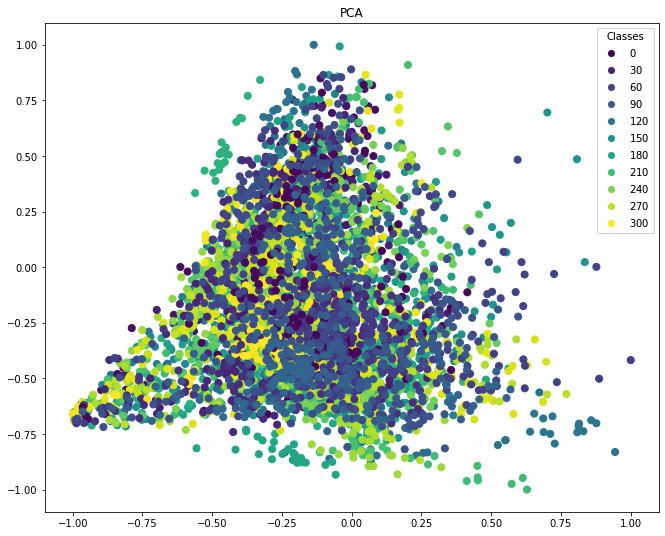

In [4]:
plot_scatter(X, Y, title='PCA')

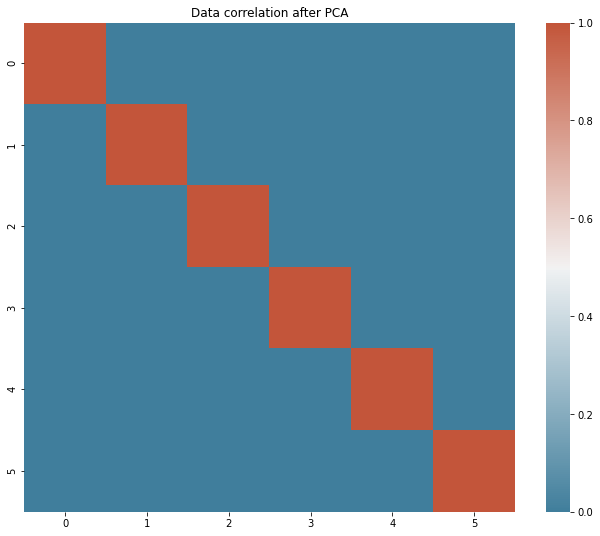

In [7]:
print_correlation_matrix(X, 'Data correlation after PCA')

In [4]:
X, Y = shuffle(X, Y)

from itertools import combinations

divider = 3
combs = list(combinations(zip(X[:len(X) // divider], Y[:len(Y) // divider]), 2))

del X, Y

In [5]:
X_train = []
Y_train = []
N = len(combs)
for i in tnrange(N):
    X_train.append(np.concatenate([combs[i][0][0], combs[i][1][0]]))

    if combs[i][0][1] == combs[i][1][1]:
        Y_train.append(1)
    else:
        Y_train.append(0)

del combs

  0%|          | 0/1528626 [00:00<?, ?it/s]

In [6]:
similar_X = []
similar_Y = []

for i in range(len(X_train)):
    if Y_train[i] == 1:
        similar_X.append(X_train[i])
        similar_Y.append(Y_train[i])

similar_count = len(similar_Y)
non_similar_X = []
non_similar_Y = []

for i in range(len(X_train)):
    if Y_train[i] == 0:
        non_similar_X.append(X_train[i])
        non_similar_Y.append(Y_train[i])

    if len(non_similar_X) == similar_count:
        break

In [7]:
X_train = np.concatenate([np.array(similar_X), np.array(non_similar_X)])
Y_train = np.concatenate([np.array(similar_Y), np.array(non_similar_Y)])
X_train, Y_train = shuffle(X_train, Y_train)

del similar_X, similar_Y, non_similar_X, non_similar_Y, similar_count

In [8]:
VALIDATION_SPLIT = 0.2
TRAIN_N = int(len(X_train) * (1 - VALIDATION_SPLIT))
X_test, Y_test = X_train[TRAIN_N:], Y_train[TRAIN_N:]
X_train, Y_train = X_train[:TRAIN_N], Y_train[:TRAIN_N]

In [9]:
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'X_train.pkl'), mode='wb') as X_train_file:
    pickle.dump(X_train, X_train_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'Y_train.pkl'), mode='wb') as Y_train_file:
    pickle.dump(Y_train, Y_train_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'X_test.pkl'), mode='wb') as X_test_file:
    pickle.dump(X_test, X_test_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'Y_test.pkl'), mode='wb') as Y_test_file:
    pickle.dump(Y_test, Y_test_file)

del X_train_file, Y_train_file, X_test_file, Y_test_file

In [2]:
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'X_train.pkl'), mode='rb') as X_train_file:
    X_train = pickle.load(X_train_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'Y_train.pkl'), mode='rb') as Y_train_file:
    Y_train = pickle.load(Y_train_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'X_test.pkl'), mode='rb') as X_test_file:
    X_test = pickle.load(X_test_file)
with open(os.path.join(Constant.CLASSIFIER_WEIGHTS_PATH, 'Y_test.pkl'), mode='rb') as Y_test_file:
    Y_test = pickle.load(Y_test_file)

del X_train_file, Y_train_file, X_test_file, Y_test_file

In [10]:
def score_classifier(classifier, X, Y, classifier_name):
    (TP, TN, FP, FN), accuracy, precision, recall, f1, specifity = classifier.score(X, Y)

    confusion_matrix = np.array([[TN, FP], [FN, TP]])

    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = [f'{value:0.0f}' for value in confusion_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in confusion_matrix.flatten() / np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(9, 9))
    plt.title(f'{classifier_name} confusion matrix')
    sns.heatmap(confusion_matrix, fmt='', cmap='Blues', annot=labels)
    plt.show()

    logger.info(f'{classifier_name} Accuracy: {accuracy:.2%}')
    logger.info(f'{classifier_name} Precision: {precision:.2%}')
    logger.info(f'{classifier_name} Recall: {recall:.2%}')
    logger.info(f'{classifier_name} F1-score: {f1:.2%}')
    logger.info(f'{classifier_name} Specifity: {specifity:.2%}')

In [11]:
svm = SVM()
svm.train(X_train, Y_train)
svm.save_weights()

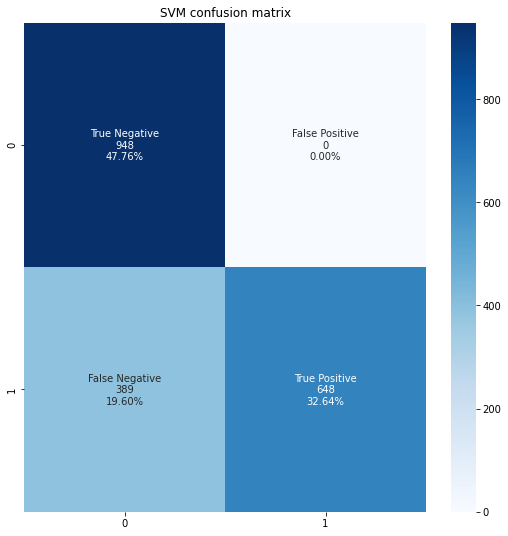

2021-05-06 19:51:13.008 | INFO     | __main__:score_classifier:17 - SVM Accuracy: 80.40%
2021-05-06 19:51:13.009 | INFO     | __main__:score_classifier:18 - SVM Precision: 100.00%
2021-05-06 19:51:13.009 | INFO     | __main__:score_classifier:19 - SVM Recall: 62.49%
2021-05-06 19:51:13.010 | INFO     | __main__:score_classifier:20 - SVM F1-score: 76.91%
2021-05-06 19:51:13.011 | INFO     | __main__:score_classifier:21 - SVM Specifity: 100.00%


In [12]:
score_classifier(svm, X_test, Y_test, 'SVM')

In [13]:
knn = KNN()
knn.train(X_train, Y_train)
knn.save_weights()

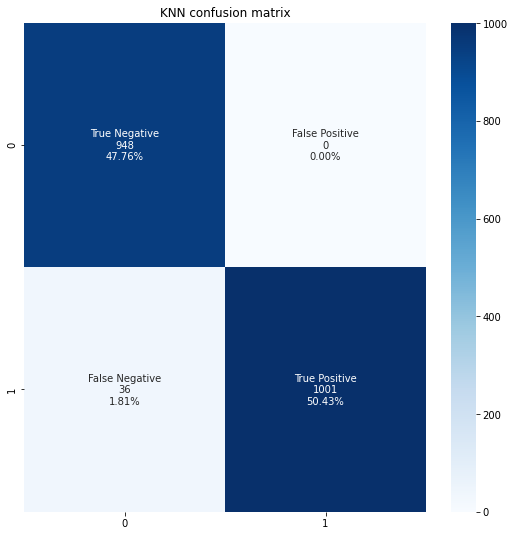

2021-05-06 19:51:13.420 | INFO     | __main__:score_classifier:17 - KNN Accuracy: 98.19%
2021-05-06 19:51:13.421 | INFO     | __main__:score_classifier:18 - KNN Precision: 100.00%
2021-05-06 19:51:13.421 | INFO     | __main__:score_classifier:19 - KNN Recall: 96.53%
2021-05-06 19:51:13.422 | INFO     | __main__:score_classifier:20 - KNN F1-score: 98.23%
2021-05-06 19:51:13.422 | INFO     | __main__:score_classifier:21 - KNN Specifity: 100.00%


In [14]:
score_classifier(knn, X_test, Y_test, 'KNN')

In [15]:
ada = Ada()
ada.train(X_train, Y_train)
ada.save_weights()

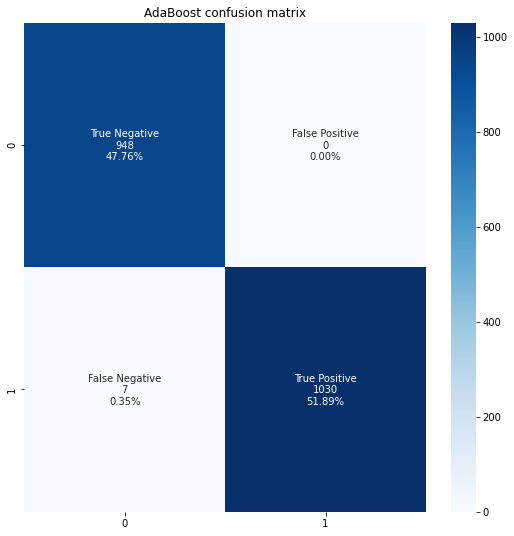

2021-05-06 19:51:14.915 | INFO     | __main__:score_classifier:17 - AdaBoost Accuracy: 99.65%
2021-05-06 19:51:14.916 | INFO     | __main__:score_classifier:18 - AdaBoost Precision: 100.00%
2021-05-06 19:51:14.916 | INFO     | __main__:score_classifier:19 - AdaBoost Recall: 99.32%
2021-05-06 19:51:14.917 | INFO     | __main__:score_classifier:20 - AdaBoost F1-score: 99.66%
2021-05-06 19:51:14.917 | INFO     | __main__:score_classifier:21 - AdaBoost Specifity: 100.00%


In [16]:
score_classifier(ada, X_test, Y_test, 'AdaBoost')
